# Scaled LDA v2

_Date:_ November 19, 2024

This notebook is second attempt at inferring topic parameters from a topic model with heterogeneous word dispersion by initializing with the topics and weights first found via inference under a standard LDA model.
We hypothesize that initializing with the "standard LDA parameters" will put is in the correct region of the optimization landscape before we unnecessarily incur these costs.

In this notebook, we implement the parameter updates under our proposed model which takes into account potentially hetereogenoeously disperesed word usages.

### Heterogeneously dispersed topic model
Specifically, we define the per-word scaling on a per-document basis, i.e. $\mathbf{\sigma}_v \in \mathbb{R}_++^{M}$,
and specify a Gamma prior with tied shape and rate parameter $\gamma_v \in \mathbb{R}_++$.
As in the standard LDA model, we draw a topic-vocabulary distribution $\mathbf{\theta}_k \in \Delta_V$ for each of $k=1,\ldots,K$ topics,
and we draw a document-topic usage distribution $\mathbf{w}_m \in \Delta_K$ for each document $m=1,\ldots,M$.
Now, we presume that we additionally draw a document-word scale for each word $v = 1, \ldots, V$,
\begin{equation}
    \sigma_{mv} \mid \gamma_v \sim \textrm{Gamma}(\gamma_v, \gamma_v).
\end{equation}
that scales the document-word usage rate, classically just a weighted sum of a word's mass across topics, $\sum_k w_{mk}\theta_{kv}$, to additionally include a stochastic draw of its global usage rate, $\sigma_{mv}\sum_k w_{mk}\theta_{kv}$. The resulting document-vocab count probability $\mathbf{\pi}_m \in \Delta_V$ is the normalized scaled document-word usage rate, with entries
\begin{equation}
    \pi_{mv} = \frac{\sigma_{mv} \sum_k w_{mk}\theta_{kv}}{\sum_{v'} \sigma_{mv'} \sum_k w_{mk}\theta_{kv'}}.
\end{equation}

The observed document-word counts are described as being generated from a conditionally multinomial distribution,
\begin{equation}
    (x_{m1}, \ldots, x_{mV}) \mid n_m, \mathbf{\sigma}_m, \mathbf{w}_m, \mathbf{\theta}
    \sim \textrm{Mult}(n_m, \mathbf{\pi}_m).
\end{equation}

**Remarks**
- This scaled LDA model is an overdispersed generalization of the standard LDA model. Specifically, the distribution over each word in a document is Gamma-Poisson distribution with shape $\gamma_v$ and rate $\gamma_v$. This distribution can thus also be re-parameterized as a negative binomial with rate $\gamma_v$ and probability $\frac{\gamma_v}{1+\gamma_v}$.
- We specify a Gamma prior with shape $\gamma_v$ and rate $\gamma_v$ such that the expected value is always 1, $\mathbb{E}[\sigma_{mv}] = 1$ for all $m$ and $v$. This sidesteps the identifiability issue that we were encountered in previous version of the model.
- We recover the standard LDA model in the limit of $\gamma_v \rightarrow \infty$ for all $v$. This results in $\mathbf{\sigma}_{m} \overset{\textrm{a.s.}}{\rightarrow}  (C, \ldots, C)$ for some constant $C \in \mathbb{R}_+$, and $\pi_{mv} = \sum_k w_{mk}\theta_{kv}$.

**Notebook scope**

In this notebook, we perform inference in an intermediate model to validate our model and algorithm. Specifically, we treat $\gamma_v$ as a hyperparameter that we (roughly) know, instead of as a parameter to be inferred. Thus, we only calculate the expected value of the auxiliary variable $\mathbf{z} \in \mathbb{N}^{M\times V \times K}$, and we aim to infer the values of parameters $\{\mathbf{\theta}, \mathbf{w}, \mathbf{\sigma}\}$.

We contrast this with the "full" model, where we compute the expected values of latent variables $\{\mathbf{z}, \mathbf{\sigma}\}$ and aim to infer the values of parameters $\{\mathbf{\sigma}, \mathbf{w}, \mathbf{\gamma}\}$. We leave this to a future notebook, after validating that we can reliably infer $\mathbf{\sigma}$.


In [1]:
from collections import namedtuple
from typing import Callable, Optional, Sequence
from jax.typing import ArrayLike
from jax import Array
KeyArray = Array

from functools import partial
import pickle
from tqdm.auto import tqdm

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

import numpy as onp

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
AutoIntLocator = mpl.ticker.MaxNLocator(nbins='auto', steps=[1,2,5,10], integer=True)

/scratch/users/eyz/miniconda3/envs/dtd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate separable topics
The LDA model implicitly assumes that the underlying latent topics are well-separated.
Sampling from a sparse Dirichlet distribution produces well-separated topics in the asymptotic limit,
but in the (very small) finite regime in which we will simulate data (i.e. $\mathcal{O}(K) = 10$),
there is no guarantee that the topics we generate satisfy this assumption.

We can generate well-seperated topics through an acceptance-rejection scheme.
Specifically, for a target $K$ topics, we will generate $\tilde{K} \gg K$ topics,
then select the $K$ subset that maximizes pairwise distance.

### Topic dissimilarity metrics

Cosine distance is used to evaluate topic dissimilarity (see Cao et al. 2009), where
\begin{equation}
D_\textrm{cosine}(\mathbf{p},\mathbf{q}) = 1 - \frac{\mathbf{p}\cdot\mathbf{q}}{\Vert \mathbf{p} \Vert_2 \Vert \mathbf{q} \Vert_2 }.
\end{equation}
where $\mathbf{p} \in \mathbb{R}^d, \mathbf{q} \in \mathbb{R}^d$ are two $d$-dimensional vectors. In our case of interest, they are specifically two vectors on the simplex $\mathbf{p} \in \Delta_d, \mathbf{q} \in \Delta_d$.

The Hellinger distance for the Dirichlet distribution was also considered
(see: _"Probabilistic distance measures of the Dirichlet and Beta distributions." (2008) [[link]](https://www.sciencedirect.com/science/article/pii/S0031320307003123)_)
but the exact application does not seem to work well for single samples (it was designed for distributions...).
The same paper above discusses why the KL divergence is not defined for the Dirichlet distributions, and therefore why it is inappropriate.

One question is why we can apply the KL divergence to samples of distributions, whereas we cannot apply the Hellinger distance to samples of the Dirichlet distribution. Mathematically, I can see why the metric is measuring samples to be much more similar than they truly are, but I'm not sure why we can use the KL divergence on individual samples and no the Hellinger distance. This will be a good question to ask the in-the-weeds channel.

See `2024-10-10-Scaled-LDA-EM-PGD.ipynb` for empirical exploration of generating separable topics and evaluating distance measures on Dirichlet samples.

In [2]:
def cosine_dist(u, v):
    """Compute cosine distance between two vectors of same length."""

    return 1 - jnp.dot(u, v) / jnp.sqrt(jnp.sum(u**2)) / jnp.sqrt(jnp.sum(v**2))

def pdist_jax(arr, fn, return_mat: bool=False):
    """Pairwise distances between observations. JAX implementations of `scipy.spatial.distances.pdist`

    Parameters
        arr: shape (N,D). Array of N observations in a D-dimensional space.
        fn: Callable. Distance function taking in two vectors of same length.
        return_mat: bool. If True, return a dense (N,N) distance matrix.
            Default: False, return the distance matrix as a condensed vector,
            of the upper triangular elements, length (N*(N-1)/2).
    
    Returns
        dists: shape (N,N) if return_mat else (N * (N-1)/2,).

    """

    mat = vmap(vmap(fn, in_axes=(0,None)), in_axes=(None,0))(arr, arr)

    if return_mat:
        return mat
    else:
        i, j = jnp.triu_indices_from(mat, 1)
        return mat.at[i,j].get()

### Procedure

Our approach is inspired by the data-generating process used by Bystrov et al. (2024). While they generate datasets by first inferring topics and weights from real document corpora (neat idea!), we simply generate synthetic topics and weights. We follow their approach in generating a superset of draws from a Dirichlet distribution, then evaluate their pairwise distances to choose a subset of topics that maximize distance.

Suppose we are interested in generating $N$ Dirichlet distributed topics. We define a minimum distance that all pairs of seleted topics must be from each other $c \in [0,1]$. Then,
1. Sample $X_i \overset{iid}{\sim} \textrm{Dir}(\alpha)$ for $i=1,\ldots,\tilde{N}$, where $\tilde{N} \gg N$.
2. Compute the pairwise distances $C(X_i,X_{i'})$ between all samples; this results in ${\tilde{N}\choose{2}} =\left(\tilde{N}(\tilde{N}-1)\right)/2$ distances.
3. Initialize the set of selected topics with the two topics with maximal pairwise distances, $Y^{(0)} = \{X_i, X_j\}$ where $(X_i, X_j) = \arg\max C(X_i,X_j)$. Track the selected topic indices, $\mathcal{J}=\{i,j\}$

    - Alternatively, we could seed the initial two topics probabilitistically, by choosing a sample pair with probability $\frac{C_k}{\sum_{k'\in \mathcal{K}C_{k'}}}$ where $\mathcal{K} = \{1, \ldots,  {\tilde{N}\choose 2}\}$.
4. While $|Y| < N$, iterate through the remaining unselected topics: 
If $C(i,j) \geq c$ for $i \in \mathcal{K}\backslash\mathcal{J}$ and for **all** $j \in \mathcal{J}$, then $Y \leftarrow Y \cup \{X_i\}$ and $\mathcal{J} \leftarrow \mathcal{J} \cup \{i\}$

5. Return $Y$.

Note that this algorithm is not guaranteed to be optimal in the sense of globally maximizing distances while all distances lie above some threshold.
It also does not guarantee that $N$ topics will be found. However, we use this algorithm because it is easy to implement. It may require some tuning of the threshold value.

**A more optimal solution (future work)**
A more optimal formulation is to find the $N$ subset of $\tilde{N}$ samples that respects the threshold conditions.
\begin{align*}
\textrm{maximize} \quad& \sum_{i,j\in\mathcal{J}, i\neq j} C(i,j) \\
\textrm{s.t. } \quad & C(i,j) \geq \; c \quad \textrm{for } i,j\in\mathcal{J}, i\neq j \\
& \vert\mathcal{J}\vert = N
\end{align*}

This feels like a variation of the assignment problem, and should have a straightforward linear programming solution. Just need to look into it :/.

I'm not even sure if the minimum threshold is necessary; that could result in an infeasible solution.

In [3]:
def generate_separable_dirichlet_samples(
    key: KeyArray,
    dim: int,
    n_samples: int,
    conc: float | Array,
    dist_fn: Callable[[Array,Array], float]=cosine_dist,
    threshold: float=None,
    n_simulated: int=None,
    ):
    """Generate seperable samples from a Dirichlet distribution.

    All samples must have a pairwise distance >= threshold, as defined by the distance_fn.

    Note! This user does not necessarily find `n_samples` that satisfy the conditions;
    topics that are not found will be a vector of 0's. Users must manually check that
    all topics have been found, e.g. `jnp.allclose(selected_topics.sum(axis=-1), 1)`.

    This function uses a for loop, which is much easier to read than a JAX scan and generally
    faster, especially for the number of samples we are looking to generate. For JAX scan
    implementation, check out the function of the same name in the 2024-10-03 notebook.

    Parameters
        key: PRNG key
        n_samples: int. Number of samples to return.
        dim: int. Dimensionality of the vectors
        conc: Concentration of Dirichlet distribution. Must be broadcastable to (dim,).
        dist_fn: Callable. Distance metric to compute separability. Default: cosine_dist
        threshold: float. Distance threshold between all topics. Value in range of dist_fn.
            If None (default), set to 90% percentile of pairwise distances in simulated samples.
        n_simulated: int. Total number of samples to simulate, should be >>n_samples
            so that we can reject samples. If None (default), set to 50*n_samples
    
    Returns
        selected_topics: shape (n_samples, dim)
            NOTE: This function does not throw an error. User must manually check that
            `jnp.allclose(selected_topics.sum(axis=-1), 1).`
        sorted_dists: shape (n_simulated*(n_simulated-1)/2,)
            All pairwise distances in the simulated samples. Used for post-hoc analysis
            of distribution parameters and threshold
        threshold: float. Distance thresholding value.
    """
    if n_simulated is None:
        n_simulated = 50 * n_samples

    conc = jnp.broadcast_to(jnp.asarray(conc, dtype=float), (dim,),)
    samples = jr.dirichlet(key, conc, (n_simulated,))  # shape (N_sim, D)

    # Calculate the pairwise distances b/t samples; sort from largest to smallest dists
    dists = pdist_jax(samples, dist_fn)  # shape P_sim := (N_sim * (N_sim-1)/2)
    sorted_dist_idxs = jnp.argsort(dists, descending=True)  # largest to smallest distances
    sorted_dists = dists[sorted_dist_idxs]

    # Set threshold, if not provided
    if threshold is None:
        threshold = jnp.percentile(dists, 10)

    # Get the sample indices, sorted by greatest pairwise distances
    ijs = jnp.stack(jnp.triu_indices(n_simulated, 1), axis=-1)  # shape (N2_sim, 2)
    ijs = ijs[sorted_dist_idxs].ravel()  # shape (B2_sim * 2)
    _, unique_sample_id_idxs = jnp.unique(ijs, return_index=True)
    sorted_sample_ids = ijs[jnp.sort(unique_sample_id_idxs)]

    # Initialize with the greatest pairwise-separable topics
    selected_samples = jnp.zeros((n_samples, dim))
    selected_samples = selected_samples.at[:2].set(samples[sorted_sample_ids[:2]])
    n_selected = 2

    for i, idx in enumerate(sorted_sample_ids[2:]):
        proposed_samples = selected_samples.at[n_selected].set(samples[idx])
        
        tmp = pdist_jax(proposed_samples[:n_selected+1], dist_fn)
        if all(tmp >= threshold):
            selected_samples = proposed_samples
            n_selected += 1

        if (n_selected >= n_samples):
            break
    
    return selected_samples, sorted_dists, threshold

In [4]:
key = jr.key(0)
dim, conc = 30, 0.2
n_samples, n_simulated = 10, 500
dist_fn, threshold = cosine_dist, 0.6

n_examples = 10

all_naive_samples, all_selected_samples = [], []
for i in range(n_examples):
    this_key = jr.fold_in(key, i)
    
    naive_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0, n_simulated=n_samples,
    )  # we reuse the custom function to generate naively; 

    selected_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0.6, n_simulated=n_simulated,
    )

    if not jnp.allclose(selected_samples.sum(axis=-1), 1, atol=0, rtol=1e-1):
        print(f"example {i}: topics not all filled", )

    all_naive_samples.append(naive_samples)
    all_selected_samples.append(selected_samples)

2024-11-19 13:36:33.991133: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


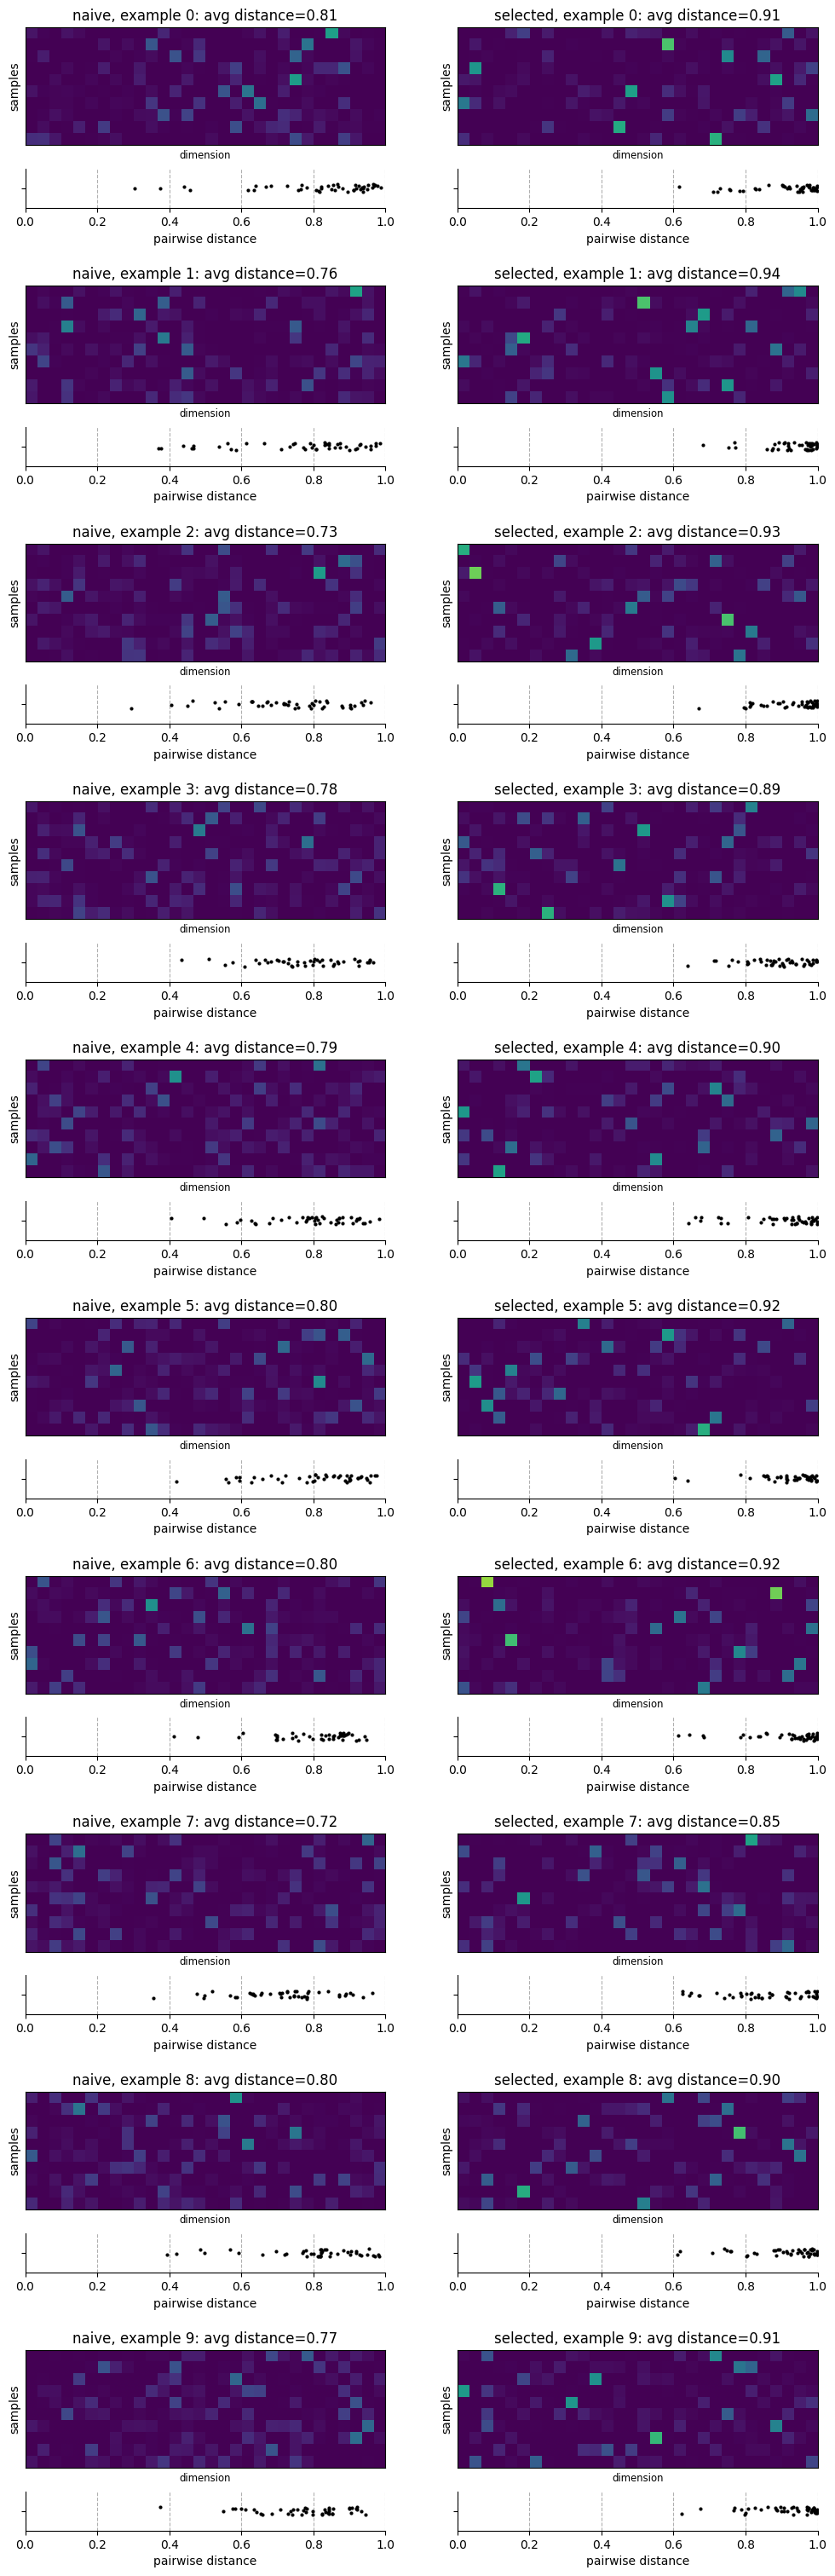

In [5]:
vmax = 1

fig = plt.figure(figsize=(12, n_examples*3))
subfigs = fig.subfigures(nrows=n_examples, ncols=1, hspace=0.1)

for i_example, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=2, ncols=2, height_ratios=[3,1], gridspec_kw={'hspace': 0.3})

    for i_subcol, samples in enumerate([all_naive_samples[i_example], all_selected_samples[i_example]]):
        dists = pdist_jax(samples, dist_fn)

        # First row: plot samples
        ax = axs[0, i_subcol]
        ax.imshow(samples, vmin=0, vmax=vmax, interpolation='none', aspect='auto')
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.set_xlabel('dimension', fontsize='small')
        ax.set_ylabel('samples')
        ax.set_title(f"{['naive', 'selected'][i_subcol]}, example {i_example}: avg distance={dists.mean():.2f}")
        
        # Second row: swarm plot fo dists
        ax = axs[1, i_subcol]
        sns.stripplot(data=dists, orient='h', color='k', size=6, marker='.', ax=ax)
        ax.set_xlabel('pairwise distance'); ax.set_xlim(0,1)
        ax.grid(axis='x', ls='--')
        ax.set_title(f'')
        sns.despine(ax=ax)


### Generate scaled LDA

Now, we randomly generate the parameters of our scaled LDA model. We denote the above procedure $\textrm{SeparatedDir}(\alpha)$ to clearly indicate our data-generating process.

In [6]:
key = jr.key(1010110)
topics_key, scales_key, weights_and_data_key = jr.split(key, 3)

**Sample topics**

Text(0.5, 1.0, 'topic-vocab distributions')

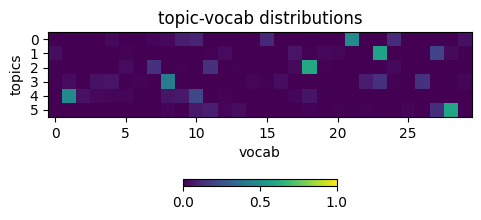

In [7]:
vocab_size = 30
n_topics = 6
topic_conc = 0.2

topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)


# -----------------------------------------------------------------------------------------------------

topics_vmax = 1

plt.figure(figsize=(6,2))
ax = plt.gca()

im = ax.imshow(topics, vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
plt.colorbar(
    im, ax=ax, fraction=0.05, extend='max' if topics_vmax < 1 else 'neither',
    orientation='horizontal', pad=0.4,
)
ax.set_ylabel('topics'); ax.set_yticks(range(n_topics))
ax.set_xlabel('vocab')
ax.set_title('topic-vocab distributions', fontsize='large')

**Sample per-document parameters**

In [8]:
n_docs = 5000
doc_length_rate = 1000
weights_conc = 1.0

# Sample doc-word scales from a range of shapes
gamma_params = jnp.array([1e-1, 1e0, 1e1, 1e3])  # let's vary the Gamma distribution shape (and scale)

scales_by_gamma = vmap(
    lambda key, gamma: jr.gamma(this_key, gamma, (n_docs, vocab_size)) / gamma
)(jr.split(scales_key, len(gamma_params)), gamma_params)  # shape (n_concs, vocab_size)

In [9]:
def sample_weights_and_data(
    key: KeyArray, topics: Array, scales: Array, n_docs: int, doc_length_rate: float, weights_conc: float=1.0
):
    """Sample document-topics and data from a scaled LDA model."""

    weights_key, lengths_key, data_key = jr.split(key, 3)

    n_topics, vocab_size = topics.shape

    # Sample document-topic weights, shape (n_docs, n_topics)
    weights_conc_ = jnp.broadcast_to(jnp.asarray(weights_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(weights_key, weights_conc_, (n_docs,))

    # Sample document lengths, shape (n_docs,)
    lengths = jr.poisson(lengths_key, doc_length_rate, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)  # convert to float for tfd.Multinomial

    # Sample data, shape (n_docs, vocab_size)
    probs = scales * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), data_key)

    return weights, data
  

In [10]:
  
# weights_by_gamma: shape (n_shapes, n_docs, n_topics)
# data_by_gamma: shape (n_shapes, n_docs, vocab_size)
weights_by_gamma, data_by_gamma = vmap(
    lambda scales: sample_weights_and_data(
        weights_and_data_key, topics, scales, n_docs, doc_length_rate, weights_conc
    )
)(scales_by_gamma)

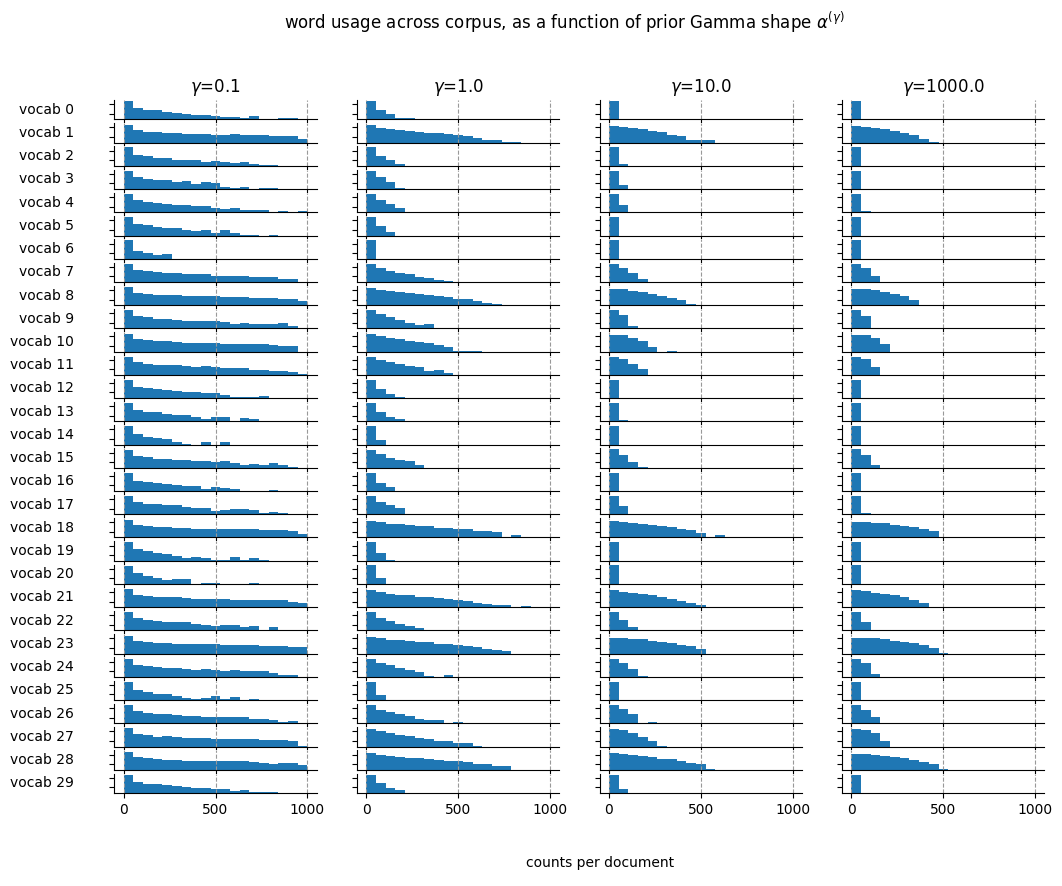

In [11]:
nrows = vocab_size
ncols = len(gamma_params)

# Share bins
n_bins = 20
bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9))

for i, gamma_shape in enumerate(gamma_params):
    axs[0,i].set_title(rf"$\gamma$={gamma_shape:.1f}", fontsize='large')

    for v in range(vocab_size):
        ax = axs[v,i]
        ax.hist(data_by_gamma[i,:,v], bin_edges, histtype='stepfilled')

        # Set y-axis to LOG scale so that we can see the heavy tails.
        ax.set_yscale('log')

        ax.grid(True, axis='x', color='0.6', ls='--')


for v, ax in enumerate(axs[:,0]):  # first column: label rows with word id, label y-axis
    # ax.set_ylabel("#", fontsize='small')
    ax.tick_params(labelleft=False)
    ax.text(-0.2, 0.5, f"vocab {v}", transform=ax.transAxes, ha='right', va='center', fontsize='medium')

# bottom row: shared x-axis label
plt.text(0.5, 0.01, f"counts per document", transform=subfigs[2].transFigure, ha='center', va='top', fontsize='medium')

# set title
fig.suptitle(r'word usage across corpus, as a function of prior Gamma shape $\alpha^{(\gamma)}$')

sns.despine()

We see that as $\gamma \rightarrow \infty$, $\sigma_{mv}\rightarrow 1$, and the word usage spread decreases $\mathbb{V}[X_v] \downarrow$.
This effect is most noticeable when $\gamma < 1.0$.

## EM with PGD algorithm

Our parameter updates for the topics, $\mathbf{\theta}_k \in \Delta_V$ for $k=1,\ldots,K$, involve minimizing the negative log likelihood of a $V$ independent Gamma variables, $f(x)$, subject to $x \in \Delta_V$. The same type of updates are also needed for the weights, $\mathbf{w}_m \in \Delta_K$, and scale, $\sigma\in\Delta_V$ parameters.

Since $f(x)$ is a convex function, one way we can solve this method is through **proximal gradient descent** (see Section 4.2 of Parikh and Boyd (2013)).

The key ingredient is the proximal operator, $\textrm{prox}_{\lambda g}$, for step size $\lambda$ and function $g$. In our case, $g$ is the simplex indicator function,
$$
g(x) = \begin{cases}0 &\textrm{if } x \in \Delta_V \\ +\infty &\textrm{otherwise}\end{cases}.
$$

The resulting proximal operator of $g$ is simply the projection onto the simplex (see e.g. derivation by [Ang (2023)](https://angms.science/doc/CVX/Proj_simplex.pdf)).
This projection step can be solved with a bisection algorithm (see Section 6.2.25 of Parikh and Boyd (2013)), or more efficiently by sorting (see [Duchi et al. (2008)](https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf)),

### Generic PGD with backtracking line search

In [12]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, n_backtrack_steps = lax.while_loop(
            _backtrack_cond, _backtrack_body, (max_stepsize, 0)
        )

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, n_steps = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

Here, we implement the simplex projection function via sorting (Duchi et al. (2008)).

An implementation of the bisection algorithm may be found in earlier notebooks
or in the original ["Convex optimization on simplex by proximal gradient descent (colab)"](https://colab.research.google.com/drive/1SI2MRM_zHfHHwQDbjQORtssg1ixu7v7x?authuser=2#scrollTo=Pa4fo_PWeZnb) notebook.

In [13]:
def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the algorithm described in

    Duchi et al. (2008), https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf,
    and following the implementation provided in Wang and Carreira-Perpinan (2013),
    https://home.ttic.edu/~wwang5/papers/SimplexProj.pdf

    Params:
        w: shape [..., D]
    """

    dim = w.shape[-1]

    # sort input vector from highest to lowest elements
    w_sorted = jnp.sort(w, axis=-1, descending=True)

    # enumerate all possible breakpoints
    mus = jnp.cumsum(w_sorted, axis=-1) - 1
    mus /= jnp.arange(dim, dtype=float) + 1

    # find index of last breakpoint for which w_sorted - mu > 0
    j = sum(w_sorted > mus) - 1

    return jnp.maximum(0, w-mus[j])

In [14]:
# Let's check that this function does what we expect!
with jnp.printoptions(precision=2):
    for name, w in [
        ("noneg vec", jnp.array([0.2, 0.9, 1.4])),
        ("real vec", jnp.array([-0.4, 0.9, 0.2])),
        ("unit simplex", jnp.array([0.33, 0.33, 0.33])),
        ("a-simplex", jnp.array([3.3, 3.3, 3.3])),
    ]:
        v = project_simplex(w, 0)
        print(f"{name}:\t proj({w})\t-> {v}")
        assert jnp.all(v >= 0) & jnp.isclose(v.sum(), 1.0)

noneg vec:	 proj([0.2 0.9 1.4])	-> [0.   0.25 0.75]
real vec:	 proj([-0.4  0.9  0.2])	-> [0.   0.85 0.15]
unit simplex:	 proj([0.33 0.33 0.33])	-> [0.33 0.33 0.33]
a-simplex:	 proj([3.3 3.3 3.3])	-> [0.33 0.33 0.33]


### Simplex-constrained independent Gamma optimziation

Now, we combine the PGD algorithm and the simplex projection operator with our objective,

$$
\underset{{\mathbf{x} \in \Delta_d}}{\textrm{maximize}}\;
f(\mathbf{x}; \mathbf{\alpha}, \mathbf{\beta}) = \sum_{i=1}^d \ln \textrm{Gamma}(x_i \mid \alpha_i, \beta_i)
$$
whre $\mathbf{\alpha}=(\alpha_1,\ldots, \alpha_d), \mathbf{\beta}=(\beta_1,\ldots,\beta_d)$ are the posterior sufficient statistics.

In [15]:
def gamma_dirichlet_pgd(x0, alpha, beta, amin=1e-4, max_stepsize=1e0, max_num_steps=100):
    
    # Standardize params to be order 1
    c = jnp.maximum(alpha.max(), beta.max())
    alpha = 1. + (alpha-1) / c
    beta = beta / c

    gamma_objective = lambda x: \
        -1.0 * tfd.Gamma(alpha, rate=beta).log_prob(jnp.clip(x, min=amin)).mean()

    return prox_grad_descent(
        gamma_objective, project_simplex, x0,
        max_stepsize=max_stepsize, max_num_steps=max_num_steps
    )

# vmap over initial params, alpha, and beta
v_gamma_dirichlet_pgd = vmap(gamma_dirichlet_pgd, in_axes=(0,0,0,None,None))

### Multinomial log likelihood

We evaluate model fit under a multinomial observation model.

In [16]:
def multinomial_ll(data, topics, weights, scales):
    """Compute multinomial LL of data given model params."""

    probs = scales * (weights @ topics)
    probs /= jnp.clip(probs.sum(axis=-1, keepdims=True), min=1e-6)  # clip to avoid dbz
    probs = jnp.clip(probs, min=1e-6)  # clip to avoid ninf in log likelihood

    return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data)

## EM-PGD - Intermediate

In [17]:
def e_step(data, topics, weights, prior_scale_conc):
    """Compute posterior expected sufficient statistics of parameters.

    TODO: Calculate expected_log_scales for gamma parameter inference

    Parameters
        X: data tensor, shape (M,V)
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (M,V,)
        prior_scale_conc: shape (V,)

    Returns
        expected_zs: expected counts allocation, shape (M, V, K)
        expected_scales: 
    """
    rhos = jnp.einsum('mk, kv -> mvk', weights, topics)
    rhos /= jnp.clip(rhos.sum(axis=-1, keepdims=True), a_min=1e-4)
    expected_zs = data[...,None] * rhos  # shape (M,V,K)

    doc_lengths = data.sum(axis=-1)
    conc = data + prior_scale_conc
    rate = jnp.einsum('m,mk,kv->mv', doc_lengths, weights, topics) + prior_scale_conc
    expected_scales = conc / rate
    
    return expected_zs, expected_scales

In [18]:
def m_step_topics(expected_zs, expected_scales, topics, weights, prior_params, max_stepsize=1e0, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    doc_lengths = expected_zs.sum(axis=(1,2))
    conc = expected_zs.sum(axis=0).T + prior_conc
    rate = jnp.einsum('m, mv,mk->kv', doc_lengths, expected_scales, weights) + prior_rate
    
    new_topics = v_gamma_dirichlet_pgd(topics, conc, rate, a_min, max_stepsize)
    return new_topics

def m_step_weights(expected_zs, expected_scales, topics, weights, prior_params, max_stepsize=1e0, a_min=1e-4):
    prior_conc, prior_rate = prior_params

    doc_lengths = expected_zs.sum(axis=(1,2))
    conc = expected_zs.sum(axis=1) + prior_conc
    rate = jnp.einsum('m,mv,kv->mk', doc_lengths, expected_scales, topics) + prior_rate

    new_weights = v_gamma_dirichlet_pgd(weights, conc, rate, a_min, max_stepsize)

    return new_weights

**Putting it together**

In [36]:
def em(
    data: Array,
    init_topics: Array,
    init_weights: Array,
    prior_topic_shape: float=1.0,
    prior_topic_rate: float=0.0,
    prior_weight_shape: float=1.0,
    prior_weight_rate: float=0.0,
    prior_scale_conc: float=1000.0,
    max_em_steps: int=10,
    max_stepsize: dict | float=1e0,
    update_topics: bool=True,
    update_weights: bool=True,
):
    """
    Params
        data: shape (M, D)
        mask: shape (M,)
            Boolean array. If True, use data in training. Else, use data for 
    """

    # Standardize max_stepsize to be dict
    if isinstance(max_stepsize, (int, float)):
        max_stepsize = {param_: max_stepsize for param_ in ('topics', 'weights')}
    assert isinstance(max_stepsize, dict)
    
    def step(carry, i):
        topics, weights = carry

        if update_topics:
            expected_zs, expected_scales = e_step(data, topics, weights, prior_scale_conc)

            topics = m_step_topics(
                expected_zs, expected_scales,
                topics, weights,
                (prior_topic_shape, prior_topic_rate),
                max_stepsize=max_stepsize['topics']
            )
        
        if update_weights:
            def inner_step(weights, _):
                
                expected_zs, expected_scales = e_step(data, topics, weights, prior_scale_conc)

                weights = m_step_weights(
                    expected_zs, expected_scales,
                    topics, weights,
                    (prior_weight_shape, prior_weight_rate),
                    max_stepsize=max_stepsize['weights']
                )

                return weights, None
            
            # weights, _ = lax.scan(inner_step, weights, length=10)
            weights, _ = inner_step(weights, None)

        ll = multinomial_ll(data, topics, weights, expected_scales).mean()

        # return (topics, weights), (ll, topics, weights)
        return (topics, weights), ll
    
    # _, (all_lls, all_topics, all_weights, all_scales) \
    #     = jax.lax.scan(step, (init_topics, init_weights, init_scales), length=max_em_steps)

    # topics: shape (n_topics, vocab_size)
    # weights: shape (n_docs, n_topics)
    # scales: shape (n_docs, vocab_size)
    (topics, weights), all_lls \
        = jax.lax.scan(step, (init_topics, init_weights), length=max_em_steps)

    # return all_lls, all_topics, all_weights, all_scales

    return all_lls, topics[None,...], weights[None,...]

### Standard LDA case: $\alpha^{\gamma}_v \rightarrow \infty$

Here, we sanity check that in the limiting case of $\alpha^{\gamma}_v \rightarrow \infty$ for all $v \in 1,\ldots,V$, the data generated is as if it was generated under a standard LDA model, and the corresponding VB algorithm can recover the topics perfectly.

In [20]:
vocab_size = 30
n_topics = 6
doc_length_rate = 1000
n_docs = 5000
weights_conc = 1.0

In [21]:
key = jr.key(1010110)
topics_key, gamma_key, scales_key, weights_and_data_key = jr.split(key, 4)

# Shape hyperparameter of (1D) Gamma-distributed scale, shape (V,)
gammas = 1e3 * jnp.ones(vocab_size)

# Scale parameter, shape (M,V)
scales = jr.gamma(scales_key, gammas, (n_docs, vocab_size)) / gammas

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)

vocab_size = 30
n_topics = 6
topic_conc = 0.2

topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)

_, standard_data = sample_weights_and_data(
    weights_and_data_key, topics, jnp.ones((n_docs,vocab_size)), n_docs, doc_length_rate, weights_conc
)


weights, data = sample_weights_and_data(
    weights_and_data_key, topics, scales, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    scales = scales,
)

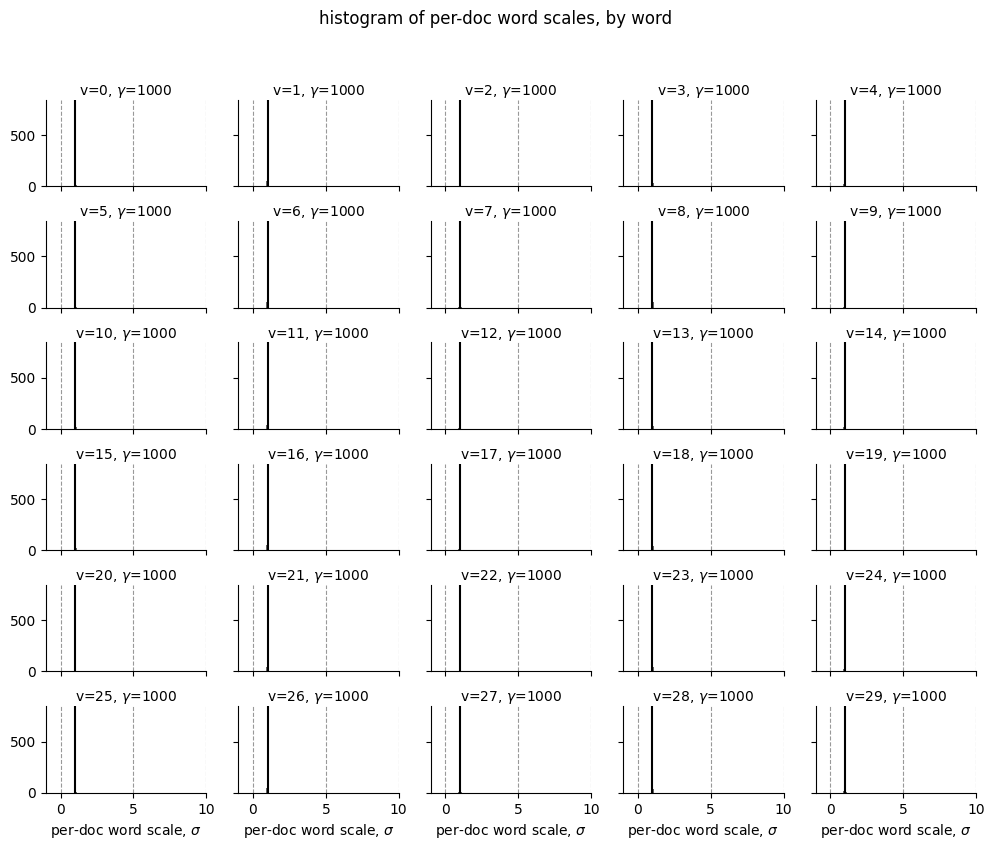

In [22]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the scales
    ax.hist(
        scales[:,v], 20, histtype='stepfilled',
        color = '0.4'
    )

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(
        0.5, 1, rf"{v=}, $\gamma$={gammas[v]:.0f}",
        ha='center', va='bottom', transform=ax.transAxes
    )
    ax.set_xlim(-1,10)

    ax.axvline(1, color='k')

for ax in axs[-1,:]:
    ax.set_xlabel(r'per-doc word scale, $\sigma$')

fig.suptitle('histogram of per-doc word scales, by word')
sns.despine()

In [23]:
standard_data = data  # let's save the data from the standard case for reference

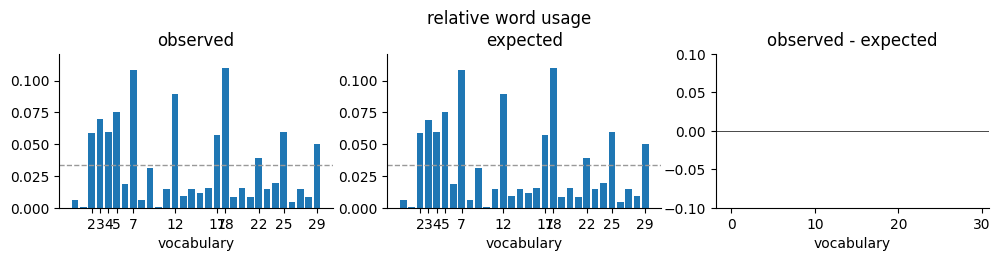

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

observed_usage = data.sum(axis=0) / data.sum()
expected_usage = (weights @ topics).mean(axis=0)

ylim = onp.max([observed_usage, expected_usage])
for ax, arr, title in zip(axs, [observed_usage, expected_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = observed_usage - expected_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

The empirical word usage across the corpus is the same as the relative word usage across the topics,
suggesting that this data is indeed similar to a standard LDA model.

#### Validate topics updates
Validate that, holding all but one coordinate to the true value, the assoicated M-step recovered the true coordinate (parameter) value.

In [25]:
n_inits = 5

rng = jr.key(4321)

batch_init_topics = jr.dirichlet(rng, jnp.ones((n_inits, n_topics, vocab_size))*100)

weights = true_params['weights']
prior_scale_conc = gammas

def em_step(topics, xs):
    expected_zs, expected_scales = e_step(data, topics, weights, prior_scale_conc)
    topics = m_step_topics(expected_zs, expected_scales, topics, weights, (0.2, 0.0), max_stepsize=1)

    dist = vmap(cosine_dist)(true_params['topics'], topics).mean()
    mse = jnp.linalg.norm(true_params['topics'] - topics, axis=-1).mean()
    nll = -multinomial_ll(data, topics, weights, expected_scales).mean()

    return topics, {'mse': mse, 'cosine_dist': dist, 'nll': nll}

batch_topics, batch_err = vmap(
    lambda topics: jax.lax.scan(em_step, topics, length=200)
)(batch_init_topics)


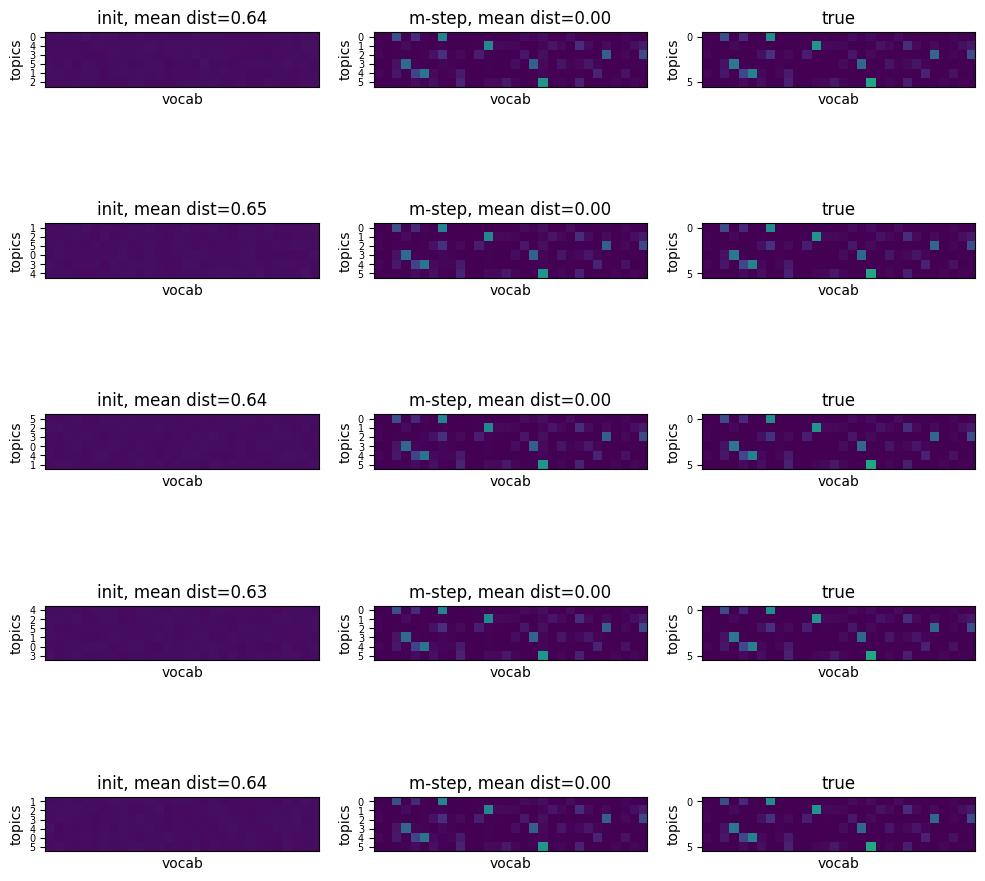

In [26]:
topics_vmax = 1

fig, axs = plt.subplots(nrows=n_inits, ncols=3, figsize=(12,12))

dict_of_things = {
    "init": batch_init_topics,
    "m-step": batch_topics,
    "true": true_params['topics']
}

for i_init in range(n_inits):
    for i, (name, topics) in enumerate([('init', batch_init_topics[i_init]), ('m-step', batch_topics[i_init])]):
        # Find the best permutation
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        
        ax = axs[i_init, i]
        im = ax.imshow(topics[i_sorted], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")

        # Label topics by their original ordering
        ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_sorted)
        
        ax.set_ylabel('topics')
        ax.set_xlabel('vocab')
        ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    
    ax = axs[i_init, -1]
    ax.set_title('true')
    ax.imshow(true_params['topics'], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
        

    ax.set_ylabel('topics')
    ax.set_xlabel('vocab'); ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')


Text(0.5, 0.98, 'topics error vs. iteration, for different inits')

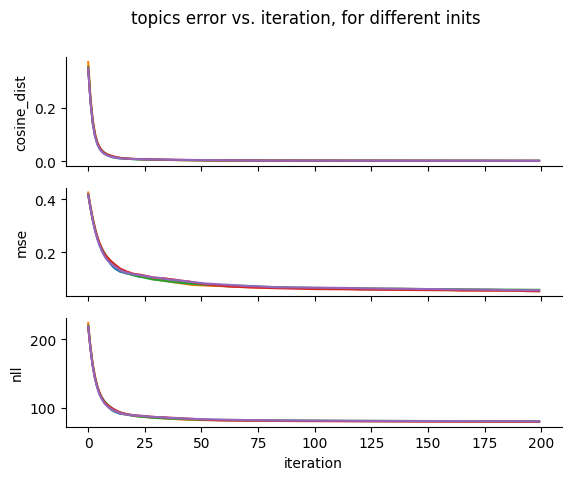

In [27]:
fig, axs = plt.subplots(nrows=len(batch_err), sharex=True)

for ax, (err_name, err_vals) in zip(axs, batch_err.items()):
    ax.plot(err_vals.T)
    ax.set_ylabel(err_name)

ax.set_xlabel('iteration')
sns.despine()

fig.suptitle('topics error vs. iteration, for different inits')

I had to really adjust the magnitude of the scales to get the M-step to even move towards the true.
If the rates truly are that high, then it seems like the M-step biases toward staying at the initial topics (since expected values are so dispersed).

However, I would have expected the M-step to update exactly to the true topics in a single step.

#### Validate weights updates

In [28]:
rng = jr.key(4321)

init_weights = jr.dirichlet(rng, jnp.ones((n_docs, n_topics))*100)

topics = true_params['topics']
prior_scale_conc = gammas

def em_step(weights, xs):
    expected_zs, expected_scales = e_step(data, topics, weights, prior_scale_conc)
    weights = m_step_weights(expected_zs, expected_scales,topics, weights, (0.5, 0.0), max_stepsize=1)

    dist = vmap(cosine_dist)(true_params['weights'], weights).mean()
    mse = jnp.linalg.norm(true_params['weights'] - weights, axis=-1).mean()
    nll = -multinomial_ll(data, topics, weights, expected_scales).mean()

    return weights, {'mse': mse, 'cosine_dist': dist, 'nll': nll}

weights, err = jax.lax.scan(em_step, init_weights, length=25)

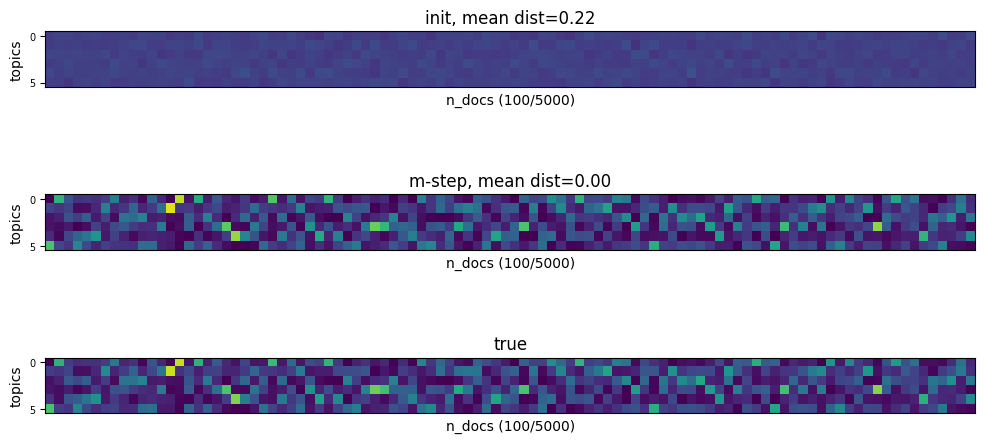

In [29]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,6))

dict_of_things = {
    "init": init_weights,
    "m-step": weights,
    "true": true_params['weights']
}

weights_vmax = dict_of_things['true'].max()

for ax, (name, weights) in zip(axs, dict_of_things.items()):
    # Find the best permutation

    if name != "true":
        final_cost = vmap(cosine_dist)(true_params['weights'], weights).mean()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        ax.set_title(name)

    im = ax.imshow(weights[:100].T, vmin=0, vmax=weights_vmax, aspect='equal', interpolation='none')
    
    ax.set_ylabel('topics')
    ax.set_xlabel(f'n_docs (100/{len(weights)})')
    ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    

Text(0.5, 0.98, 'weights coordinate error vs iteration')

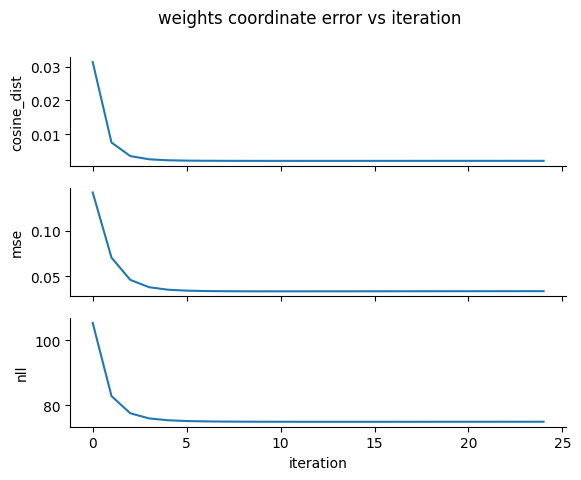

In [30]:
fig, axs = plt.subplots(nrows=len(err), sharex=True)

for ax, (err_name, err_vals) in zip(axs, err.items()):
    ax.plot(err_vals)
    ax.set_ylabel(err_name)

ax.set_xlabel('iteration')
sns.despine()

fig.suptitle('weights coordinate error vs iteration')

We can recover the true weights with just 5 iterations, in this idealized scenario.

#### Full inference

In [37]:
# ~6 minutes for 5 inits, 8 topics, 5000 docs, 30 words
n_inits = 5
n_topics = 8

# =====================
# Initialize parameters
rng = jr.key(4321)
topics_key, weights_key = jr.split(rng, 2)

batch_init_topics = jr.dirichlet(rng, 0.1*jnp.ones((n_inits, n_topics, vocab_size)))
batch_init_weights = jr.dirichlet(rng, jnp.ones((n_inits, n_docs, n_topics)))

# =======================
# Specify hyperparameters
prior_topic_shape = 0.1
prior_weight_shape = 1.0
prior_scale_conc = gammas
max_em_steps = 200

batch_em = vmap(lambda topics, weights: em(
    data,
    topics, weights,
    prior_topic_shape=prior_topic_shape,
    prior_weight_shape=prior_weight_shape,
    prior_scale_conc=prior_scale_conc,
    max_em_steps=max_em_steps
))

# batch_topics: (n_inits, n_em_steps, n_topics, vocab_size)
batch_lls, batch_topics, batch_weights = batch_em(batch_init_topics, batch_init_weights)

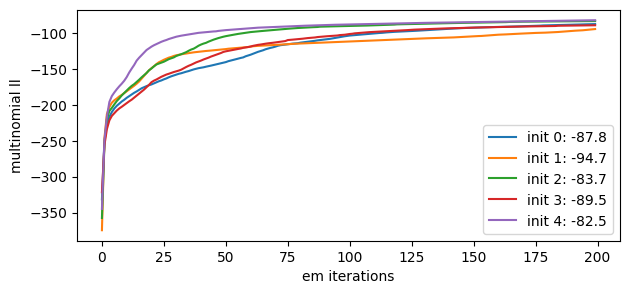

In [38]:
plt.figure(figsize=(7,3))
lines = plt.plot(batch_lls.T)
plt.xlabel('em iterations')
plt.ylabel('multinomial ll')
plt.legend(handles=lines, labels=[f'init {i}: {ll:.1f}' for i, ll in enumerate(batch_lls[:,-1])])

Text(0, 0.5, 'topics')

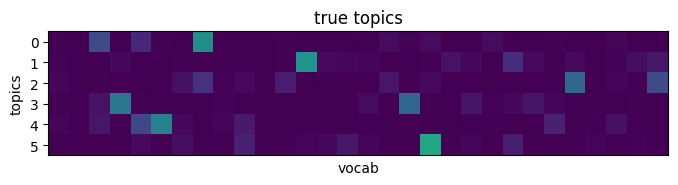

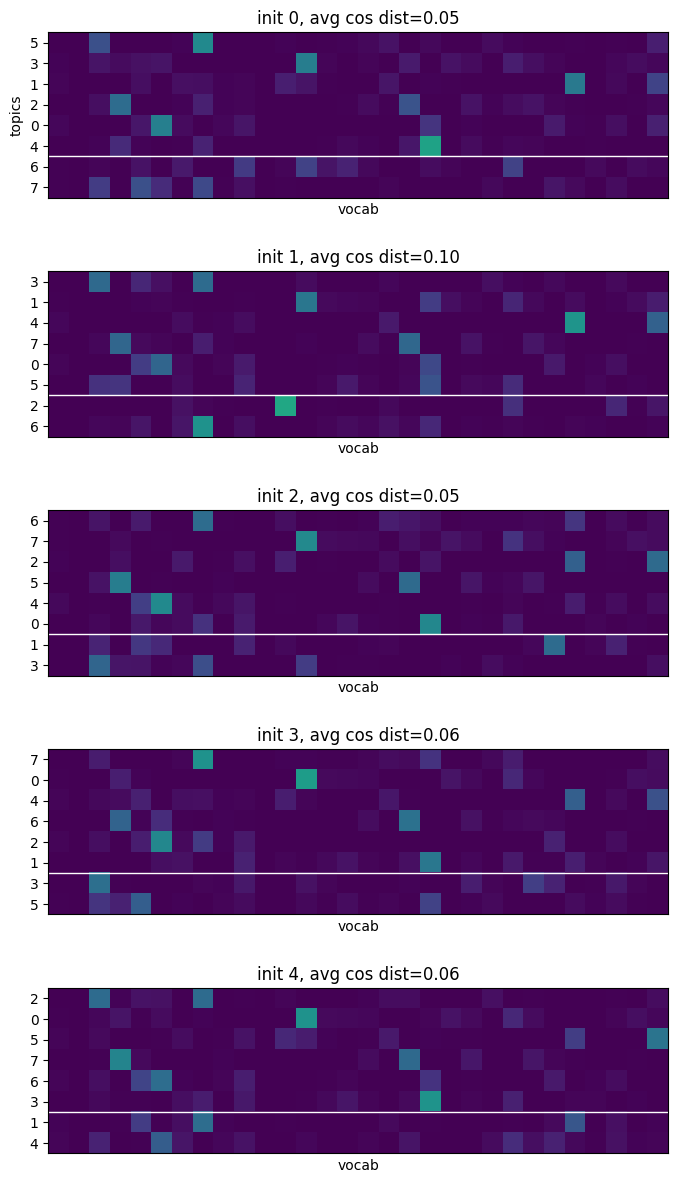

In [42]:
topics_vmax = 1

plt.figure(figsize=(8,4))
ax = plt.gca()
ax.imshow(true_params['topics'], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
ax.set_yticks(onp.arange(len(true_params['topics'])))
ax.set_ylabel('topics')
ax.set_xlabel('vocab')
ax.tick_params(bottom=False, labelbottom=False)
plt.title('true topics')

# Now, show the results
fig, axs = plt.subplots(nrows=n_inits, figsize=(8, 3*n_inits))

for i, (ax, topics) in enumerate(zip(axs, batch_topics[:,-1])):
    # Find the best permutation. Keep the discarded topics.
    cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
    _, i_sorted = linear_sum_assignment(cost_matrix)
    i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
    i_permute = onp.concatenate([i_sorted, i_discarded])
    
    final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
    ax.set_title(f"init {i}, avg cos dist={final_cost:.2f}")

    # Show topics
    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    

    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_xlabel('vocab')
    
axs[0].set_ylabel('topics')
    

Indeed, the standard LDA VB algorithm recovers the true topics. We are sane.

### Homogeneously overdispersed case, $\alpha^{\gamma}_v \rightarrow 0$

Now, let's consider the other extreme, where all words are overdispersed, $\alpha^{\gamma}_v \rightarrow 0$ for all $v \in 1,\ldots,V$.

However, the words are all similarly overdispersed. So, we expect the VB algorithm to still do fairly okay!

In [43]:
key = jr.key(321834)
topics_key, scales_key, weights_and_data_key = jr.split(key, 3)

# Shape hyperparameter of (1D) Gamma-distributed scale, shape (V,)
gammas = 10 * jnp.ones(vocab_size)

# Scale parameter, shape (M,V)
scales = jr.gamma(scales_key, gammas, (n_docs, vocab_size)) / gammas

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)

vocab_size = 30
n_topics = 6
topic_conc = 0.2

topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)

weights, data = sample_weights_and_data(
    weights_and_data_key, topics, scales, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    scales = scales,
)

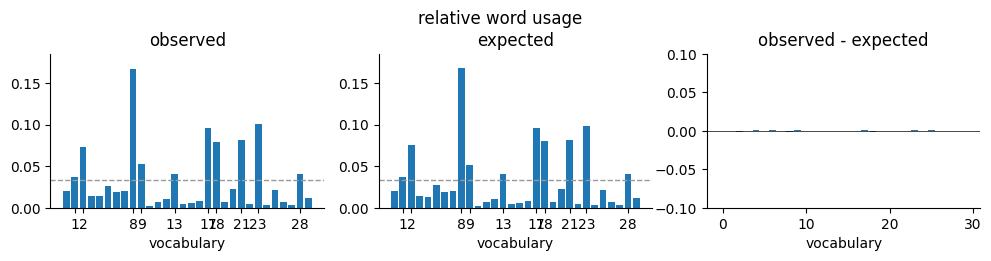

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

data_rel_usage = data.sum(axis=0) / data.sum()
topics_rel_usage = topics.sum(axis=0) / topics.sum()
ylim = onp.max([data_rel_usage, topics_rel_usage])
for ax, arr, title in zip(axs, [data_rel_usage, topics_rel_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = data_rel_usage - topics_rel_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

We see some greater greater differences in relative word usage.
Interestingly, when rate parameters induce much greater dispersion of word usage, but that dispersion is the same the relative word usages are still very similar (but not exactly the same) as the word usage by the latent topics.

One way we can think of this is as the word scales $(\gamma_1, \ldots, \gamma_v)$ being Dirichlet distributed (since they all share the same Gamma rate parameter under our formulation).

Thus, we expect the VB algorithm to recover the true topics fairly well.

#### Initialization from scratch

In [96]:
# ~6 minutes for 5 inits, 8 topics, 5000 docs, 30 words
n_inits = 5
n_topics = 6

# =====================
# Initialize parameters
rng = jr.key(5432)
topics_key, weights_key = jr.split(rng, 2)

batch_init_topics = jr.dirichlet(rng, 0.1*jnp.ones((n_inits, n_topics, vocab_size)))
batch_init_weights = jr.dirichlet(rng, jnp.ones((n_inits, n_docs, n_topics)))

# =======================
# Specify hyperparameters
prior_topic_shape = 0.1
prior_weight_shape = 1.0
prior_scale_conc = gammas
max_em_steps = 500

batch_em = vmap(lambda topics, weights: em(
    data,
    topics, weights,
    prior_topic_shape=prior_topic_shape,
    prior_weight_shape=prior_weight_shape,
    prior_scale_conc=prior_scale_conc,
    max_em_steps=max_em_steps
))

# batch_topics: (n_inits, n_em_steps, n_topics, vocab_size)
batch_lls, batch_topics, batch_weights = batch_em(batch_init_topics, batch_init_weights)

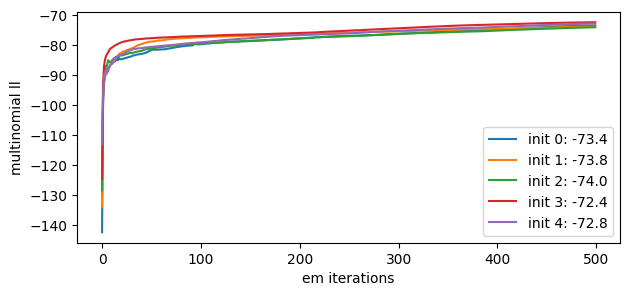

In [97]:
plt.figure(figsize=(7,3))
lines = plt.plot(batch_lls.T)
plt.xlabel('em iterations')
plt.ylabel('multinomial ll')
plt.legend(handles=lines, labels=[f'init {i}: {ll:.1f}' for i, ll in enumerate(batch_lls[:,-1])])

Text(0, 0.5, 'topics')

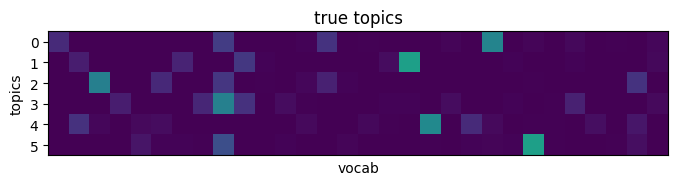

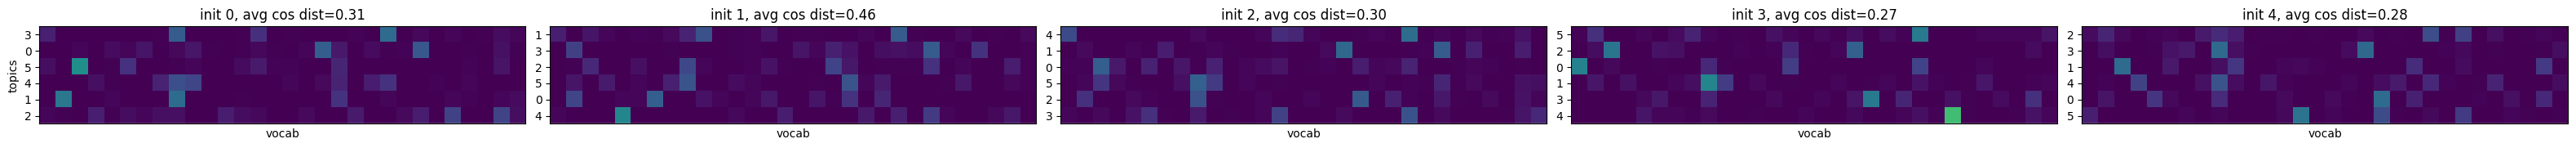

In [100]:
topics_vmax = 1

plt.figure(figsize=(8,4))
ax = plt.gca()
ax.imshow(true_params['topics'], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
ax.set_yticks(onp.arange(len(true_params['topics'])))
ax.set_ylabel('topics')
ax.set_xlabel('vocab')
ax.tick_params(bottom=False, labelbottom=False)
plt.title('true topics')

# Now, show the results
fig, axs = plt.subplots(ncols=n_inits, figsize=(8*n_inits, 3), gridspec_kw={'wspace': 0.05})

for i, (ax, topics) in enumerate(zip(axs, batch_topics[:,-1])):
    # Find the best permutation. Keep the discarded topics.
    cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
    _, i_sorted = linear_sum_assignment(cost_matrix)
    i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
    i_permute = onp.concatenate([i_sorted, i_discarded])
    
    final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
    ax.set_title(f"init {i}, avg cos dist={final_cost:.2f}")

    # Show topics
    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    

    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_xlabel('vocab')
    
axs[0].set_ylabel('topics')
    

#### Initialization from VB parameters

Here, we examine how the algorithm performs when initializing from VB parameters

**VB fit**

In [83]:
n_inits = 5
n_topics = 6

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

**Improving with EM-PGD**

In [84]:
batch_init_topics = all_topics # from vb
batch_init_weights = all_weights

# =======================
# Specify hyperparameters
prior_topic_shape = 0.1
prior_weight_shape = 1.0
prior_scale_conc = gammas
max_em_steps = 1000

batch_em = vmap(lambda topics, weights: em(
    data, topics, weights,
    prior_topic_shape=prior_topic_shape,
    prior_weight_shape=prior_weight_shape,
    prior_scale_conc=prior_scale_conc,
    max_em_steps=max_em_steps
))

# batch_topics: (n_inits, n_em_steps, n_topics, vocab_size)
batch_lls, batch_topics, batch_weights = \
        batch_em(batch_init_topics, batch_init_weights)

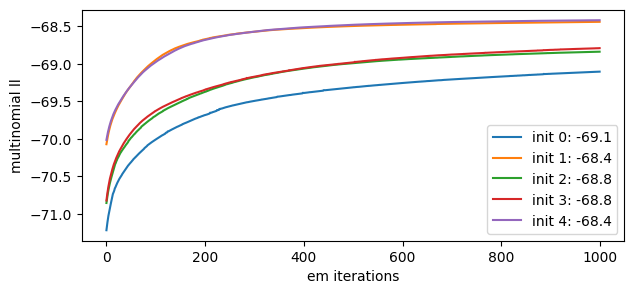

In [85]:
plt.figure(figsize=(7,3))
lines = plt.plot(batch_lls.T)
plt.xlabel('em iterations')
plt.ylabel('multinomial ll')
plt.legend(handles=lines, labels=[f'init {i}: {ll:.1f}' for i, ll in enumerate(batch_lls[:,-1])])

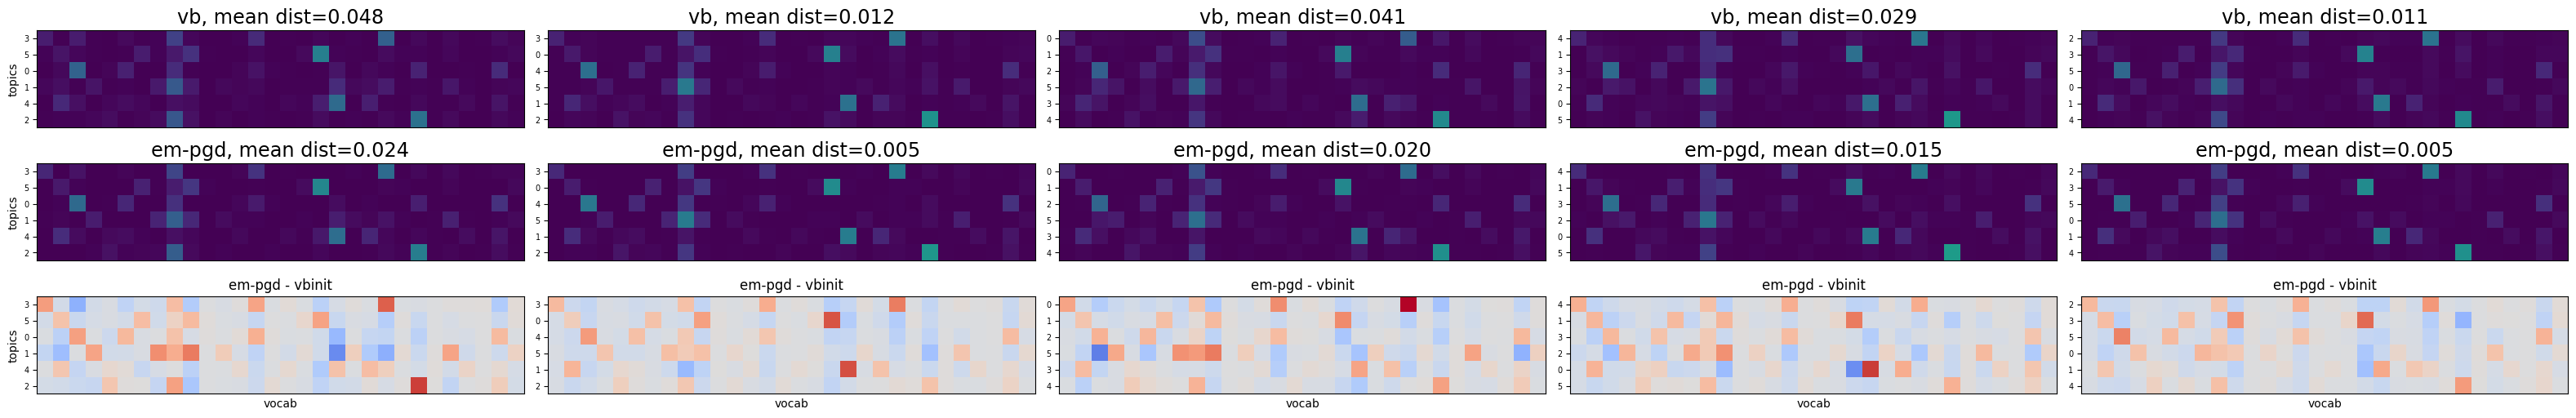

In [95]:
topics_vmax = 1

# Now, show the results
dict_of_things = {
    "vb": batch_init_topics,
    "em-pgd": batch_topics[:,0],
    "diff": batch_topics[:,0] - batch_init_topics,
    # "true": onp.tile(true_params['topics'], (n_inits, 1,1)),
}

diff_vmax = onp.maximum(onp.abs(dict_of_things['diff'].min()), dict_of_things['diff'].max())

# fig, axs = plt.subplots(nrows=n_inits, ncols=len(dict_of_things), figsize=(16, 3*n_inits))
fig, axs = plt.subplots(ncols=n_inits, nrows=len(dict_of_things), figsize=(8*n_inits,6), gridspec_kw={'wspace': 0.05})

for i_init in range(n_inits):
    for i, (name, topics) in enumerate(dict_of_things.items()):
        topics = topics[i_init]

        # Find the best permutation
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        
        # ax = axs[i_init, i]
        ax = axs[i, i_init]
        if name == 'diff':
            im_kwargs = {
                'cmap': 'coolwarm',
                'vmin': -diff_vmax,
                'vmax': diff_vmax,
            }
            ax.set_title('em-pgd - vbinit')
        else:
            im_kwargs = {
                'cmap': 'viridis',
                'vmin': 0,
                'vmax': topics_vmax,
            }
            ax.set_title(f"{name}, mean dist={final_cost:.3f}", fontsize='xx-large')
        im = ax.imshow(topics[i_sorted], aspect='equal', interpolation='none', **im_kwargs)
        

        # Label topics by their original ordering
        ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_sorted)
        
        ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')


for ax in axs[:,0]:
    ax.set_ylabel('topics')

for ax in axs[-1,:]:
    ax.set_xlabel('vocab')
    

In [87]:
diff_vmax

np.float32(0.05872473)

### Inhomogeneous dispersion, $0 \ll \alpha^{\gamma}_v < \infty$

Now, we vary the dispersion hyperparameter over words, such $\alpha^{\gamma}_v$ is not the same for all $v$. I expect the inferred parameters to begin exhibiting the pathology of many topics placing high concentration on the same highly observed words.

We will sample $\gamma_v \sim \textrm{Uniform}(0,1)$.

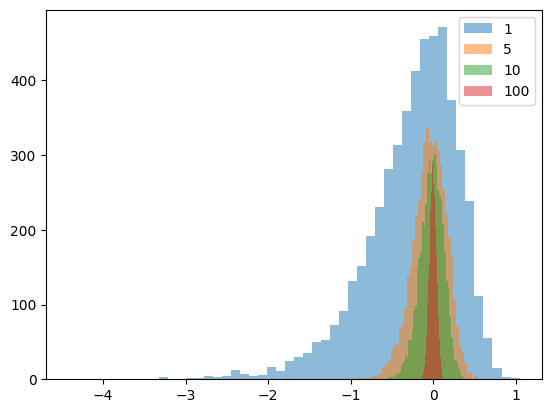

In [44]:
gammas = jnp.array([1,5,10,100])
scales = jr.gamma(scales_key, gammas, (5000,len(gammas))) / gammas

for i in range(len(gammas)):
    plt.hist(jnp.log10(scales[:,i]), 50, alpha=0.5, color=f'C{i}', label=f'{gammas[i]}')

plt.legend()

Orange distribution: log10 range between (-0.5, 0.5).
This implies syllables either get down-used by $1/\sqrt{10}\approx 1/3$ or up-used by $\sqrt{10}=3$.

#### Generate data

In [101]:
vocab_size = 30
n_topics = 6
doc_length_rate = 100
n_docs = 50
weights_conc = 1.0

# ----

key = jr.key(1010110)
topics_key, gamma_key, scales_key, weights_and_data_key = jr.split(key, 4)

gammas = jr.uniform(gamma_key, vocab_size, minval=5, maxval=20)
scales = jr.gamma(scales_key, gammas, (n_docs, vocab_size)) / gammas
scales = jnp.clip(scales, min=1e-3)

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)

vocab_size = 30
n_topics = 6
topic_conc = 0.2

topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)

_, standard_data = sample_weights_and_data(
    weights_and_data_key, topics, jnp.ones(vocab_size), n_docs, doc_length_rate, weights_conc
)
weights, data = sample_weights_and_data(
    weights_and_data_key, topics, scales, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    scales = scales,
)

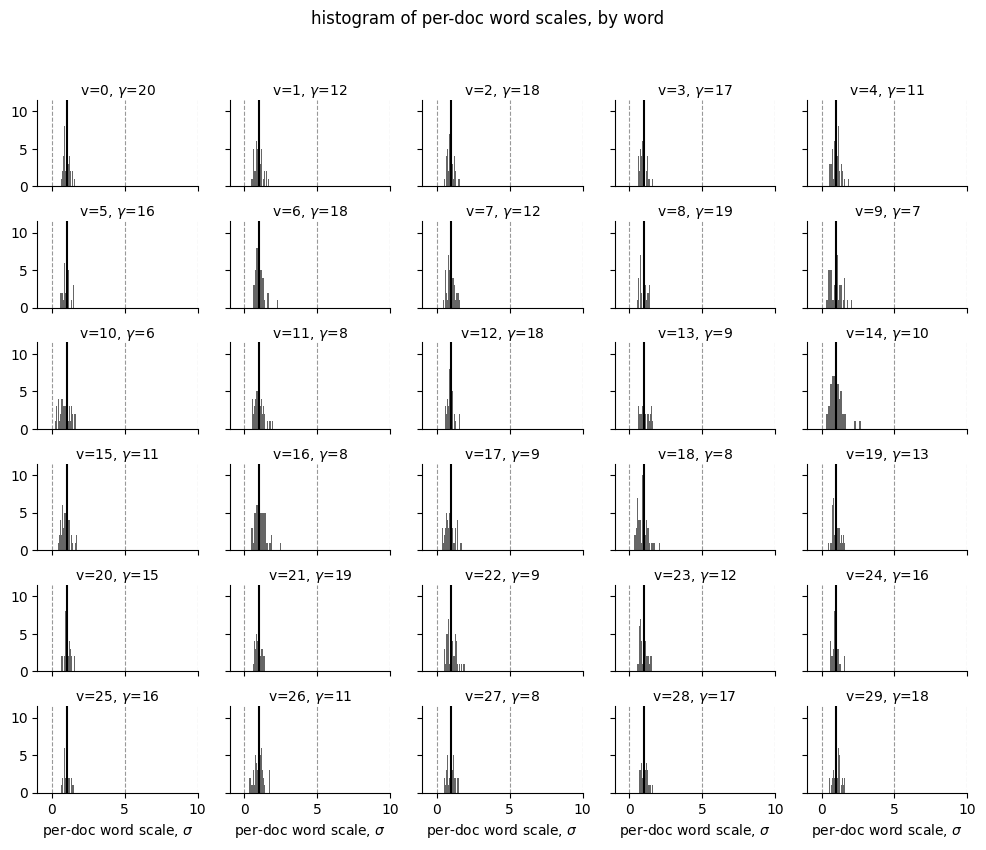

In [102]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the scales
    ax.hist(
        scales[:,v], 20, histtype='stepfilled',
        color = '0.4'
    )

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(
        0.5, 1, rf"{v=}, $\gamma$={gammas[v]:.0f}",
        ha='center', va='bottom', transform=ax.transAxes
    )
    ax.set_xlim(-1,10)

    ax.axvline(1, color='k')

for ax in axs[-1,:]:
    ax.set_xlabel(r'per-doc word scale, $\sigma$')

fig.suptitle('histogram of per-doc word scales, by word')
sns.despine()

Text(0.5, 0.95, 'observed word usage')

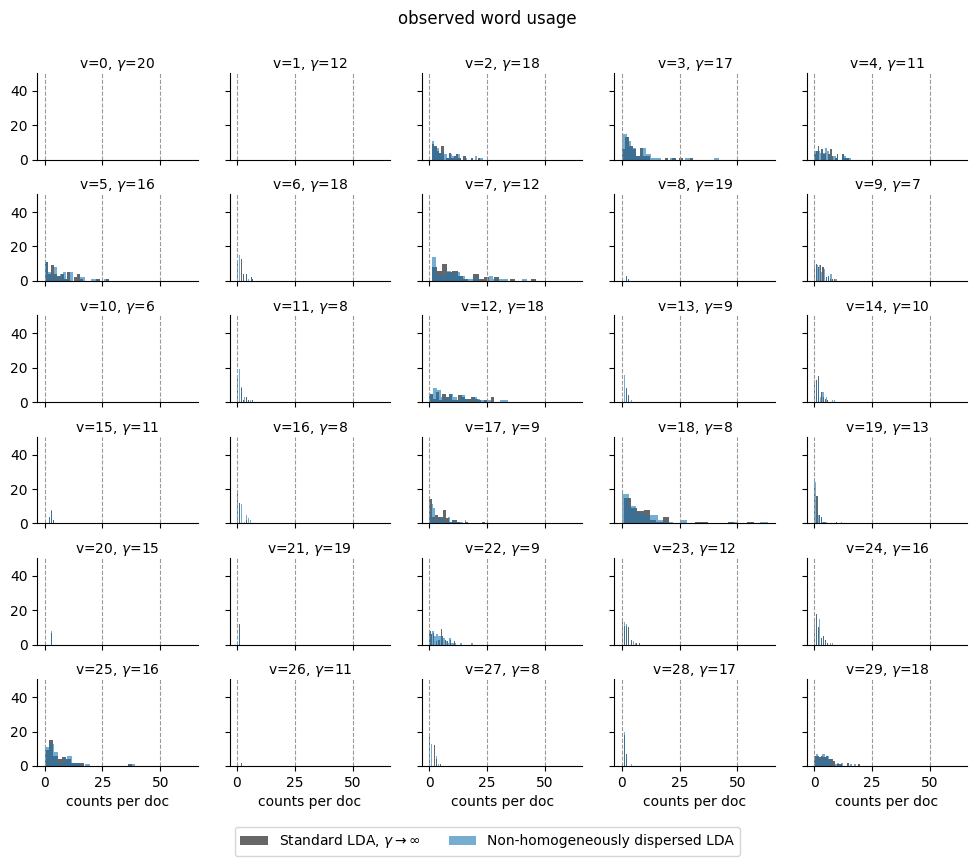

In [103]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

# Share bins
# n_bins = 20
# bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the data generated from a standard LDA
    ax.hist(
        standard_data[:,v], 20, histtype='stepfilled',
        label=r'Standard LDA, $\gamma \rightarrow \infty$',
        color = '0.4'
    )

    # Plot this data
    ax.hist(
        data[:,v], 20, histtype='stepfilled',
        label=r'Non-homogeneously dispersed LDA',
        fc='C0', alpha=0.6
    )

    # Set y-axis to LOG scale so that we can see the heavy tails.
    # ax.set_yscale('log')

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(
        0.5, 1, rf"{v=}, $\gamma$={gammas[v]:.0f}",
        ha='center', va='bottom', transform=ax.transAxes
    )

for ax in axs[-1,:]:
    ax.set_xlabel('counts per doc')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], bbox_to_anchor=[0.5, 0.05], loc='upper center', ncols=2)
sns.despine()

fig.suptitle('observed word usage', y=0.95)

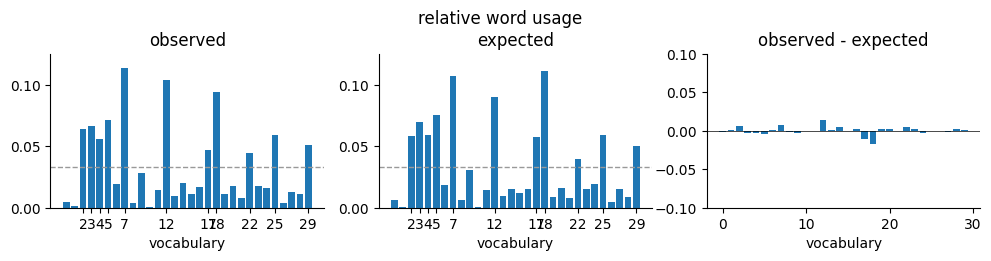

In [104]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

observed_usage = data.sum(axis=0) / data.sum()
# expected_usage = (true_params['weights']@true_params['topics']).mean(axis=0)
expected_usage = (true_params['topics']).mean(axis=0)
ylim = onp.max([observed_usage, expected_usage])
for ax, arr, title in zip(axs, [observed_usage, expected_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = observed_usage - expected_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

I am surprised that we do not see a greater difference in observed (including the scale) and expected word usage (based solely on topic distributions).

Here, we see words with high aggregated mass across topic-vocab distributions (first row) have low-to-median gamma values. This indicates that these words have greater dispersion on average.
The expected values are the same, which may be why we don't see such a great difference. However, let's keep an eye on this...

#### EM-PGD

In [119]:
# ~6 minutes for 5 inits, 8 topics, 5000 docs, 30 words
n_inits = 5
n_topics = 6

# =====================
# Initialize parameters
rng = jr.key(5432)
topics_key, weights_key, scales_key = jr.split(rng, 3)

batch_init_topics = jr.dirichlet(rng, 100*jnp.ones((n_inits, n_topics, vocab_size)))

batch_init_weights = jr.dirichlet(rng, 100*jnp.ones((n_inits, n_docs, n_topics)))

# =======================
# Specify hyperparameters
prior_topic_shape = 0.1
prior_weight_shape = 1.0
prior_scale_conc = gammas
# prior_scale_conc = 1000 * jnp.ones(vocab_size)
max_em_steps = 1000

batch_em = vmap(lambda topics, weights: em(
    data,
    topics, weights, 
    prior_topic_shape=prior_topic_shape,
    prior_weight_shape=prior_weight_shape,
    prior_scale_conc=prior_scale_conc,
    max_em_steps=max_em_steps
))

# batch_topics: (n_inits, n_em_steps, n_topics, vocab_size)
batch_lls, batch_topics, batch_weights = \
        batch_em(batch_init_topics, batch_init_weights)

In [116]:
batch_lls_, batch_topics, batch_weights = \
        batch_em(batch_topics[:,-1], batch_weights[:,-1])
batch_lls = jnp.concatenate([batch_lls, batch_lls_], axis=-1)

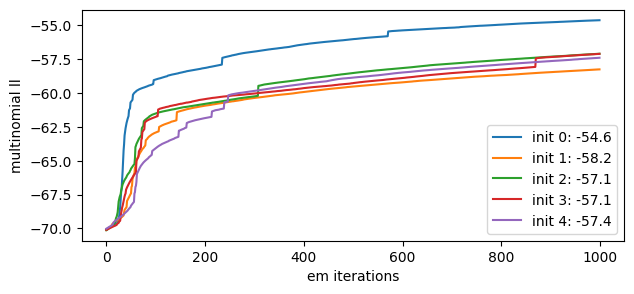

In [117]:
plt.figure(figsize=(7,3))
lines = plt.plot(batch_lls.T)
plt.xlabel('em iterations')
plt.ylabel('multinomial ll')
plt.legend(handles=lines, labels=[f'init {i}: {ll:.1f}' for i, ll in enumerate(batch_lls[:,-1])])

Text(0, 0.5, 'topics')

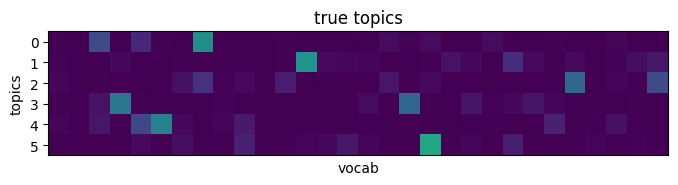

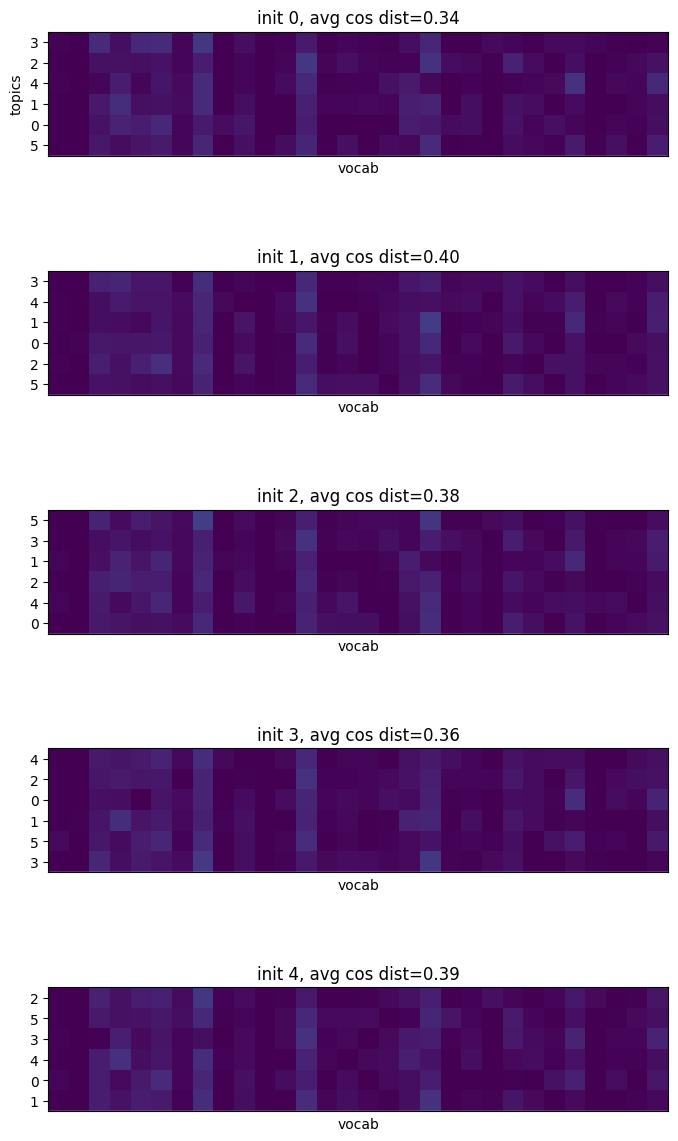

In [118]:
topics_vmax = 1

plt.figure(figsize=(8,4))
ax = plt.gca()
ax.imshow(true_params['topics'], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
ax.set_yticks(onp.arange(len(true_params['topics'])))
ax.set_ylabel('topics')
ax.set_xlabel('vocab')
ax.tick_params(bottom=False, labelbottom=False)
plt.title('true topics')

# Now, show the results
fig, axs = plt.subplots(nrows=n_inits, figsize=(8, 3*n_inits))

for i, (ax, topics) in enumerate(zip(axs, batch_topics[:,-1])):
    # Find the best permutation. Keep the discarded topics.
    cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
    _, i_sorted = linear_sum_assignment(cost_matrix)
    i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
    i_permute = onp.concatenate([i_sorted, i_discarded])
    
    final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
    ax.set_title(f"init {i}, avg cos dist={final_cost:.2f}")

    # Show topics
    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    

    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_xlabel('vocab')
    
axs[0].set_ylabel('topics')

#### Initialize from VB params

**VB fit**

In [109]:
n_inits = 5
n_topics = 8

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    lls = multinomial_ll(data, topics, weights, jnp.ones(vocab_size)).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

Text(0, 0.5, 'topics')

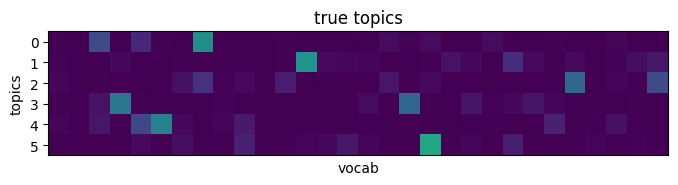

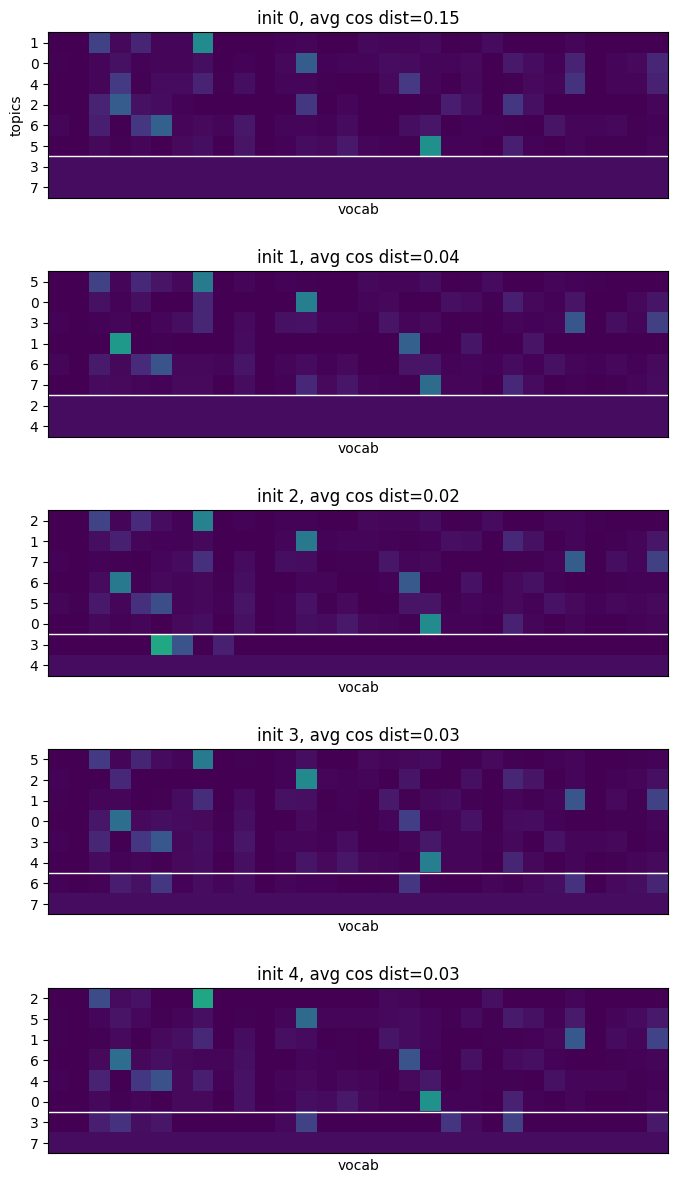

In [110]:
topics_vmax = 1

plt.figure(figsize=(8,4))
ax = plt.gca()
ax.imshow(true_params['topics'], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
ax.set_yticks(onp.arange(len(true_params['topics'])))
ax.set_ylabel('topics')
ax.set_xlabel('vocab')
ax.tick_params(bottom=False, labelbottom=False)
plt.title('true topics')

# Now, show the results
fig, axs = plt.subplots(nrows=n_inits, figsize=(8, 3*n_inits))

for i, (ax, topics) in enumerate(zip(axs, all_topics)):
    # Find the best permutation. Keep the discarded topics.
    cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
    _, i_sorted = linear_sum_assignment(cost_matrix)
    i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
    i_permute = onp.concatenate([i_sorted, i_discarded])
    
    final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
    ax.set_title(f"init {i}, avg cos dist={final_cost:.2f}")

    # Show topics
    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    

    ax.tick_params(bottom=False, labelbottom=False)
    ax.set_xlabel('vocab')
    
axs[0].set_ylabel('topics')
    

LOL so standard VB did really well. But this is because the observed word usage vs. expected usage aggregated over topics was very close to zero. I need to go revisit why -- I would have thought there to be much greater varioability in word usages. The poorer performance of our algorithm can be exaplained by this, since I gave it the true gamma hyperparameters (which expects much greater variance)

**Fine-tune with EM-PGD**

In [111]:
batch_init_topics = all_topics # from vb
batch_init_weights = all_weights

# =======================
# Specify hyperparameters
prior_topic_shape = 0.1
prior_weight_shape = 1.0
prior_scale_conc = gammas
max_em_steps = 1000

batch_em = vmap(lambda topics, weights: em(
    data, topics, weights,
    prior_topic_shape=prior_topic_shape,
    prior_weight_shape=prior_weight_shape,
    prior_scale_conc=prior_scale_conc,
    max_em_steps=max_em_steps
))

# batch_topics: (n_inits, n_em_steps, n_topics, vocab_size)
batch_lls, batch_topics, batch_weights = \
        batch_em(batch_init_topics, batch_init_weights)

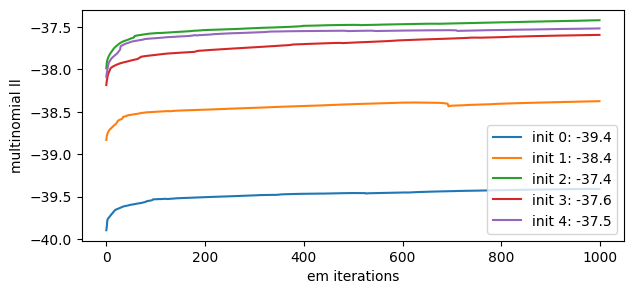

In [112]:
plt.figure(figsize=(7,3))
lines = plt.plot(batch_lls.T)
plt.xlabel('em iterations')
plt.ylabel('multinomial ll')
plt.legend(handles=lines, labels=[f'init {i}: {ll:.1f}' for i, ll in enumerate(batch_lls[:,-1])])

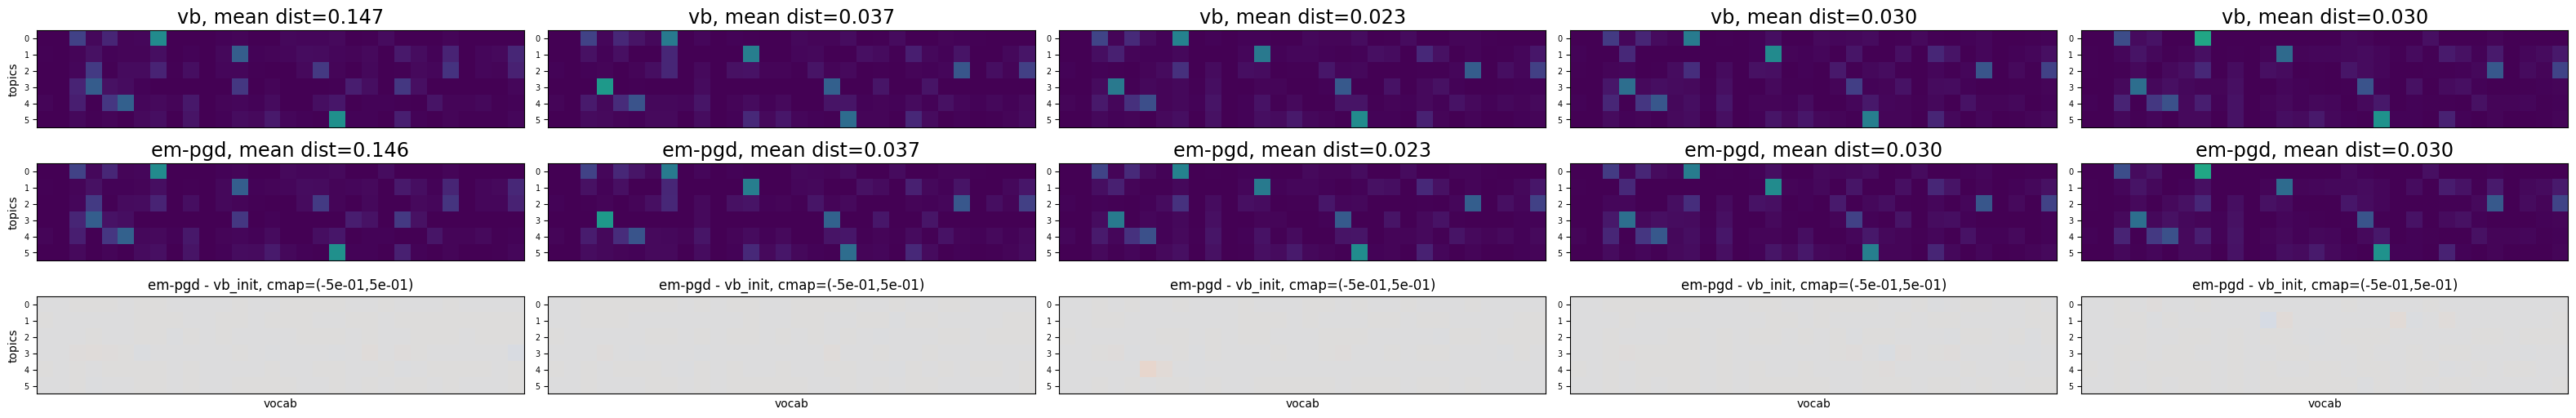

In [114]:
topics_vmax = 1

# Now, show the results
dict_of_things = {
    "vb": batch_init_topics,
    "em-pgd": batch_topics[:,0],
    "diff": batch_topics[:,0] - batch_init_topics,
    # "true": onp.tile(true_params['topics'], (n_inits, 1,1)),
}

diff_vmax = onp.maximum(onp.abs(dict_of_things['diff'].min()), dict_of_things['diff'].max())

# fig, axs = plt.subplots(nrows=n_inits, ncols=len(dict_of_things), figsize=(16, 3*n_inits))
fig, axs = plt.subplots(ncols=n_inits, nrows=len(dict_of_things), figsize=(8*n_inits,6), gridspec_kw={'wspace': 0.05})

for i_init in range(n_inits):
    for i, (name, topics) in enumerate(dict_of_things.items()):
        topics = topics[i_init]

        # Find the best permutation
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        
        # ax = axs[i_init, i]
        ax = axs[i, i_init]
        if name == 'diff':
            im_kwargs = {
                'cmap': 'coolwarm',
                'vmin': -diff_vmax,
                'vmax': diff_vmax,
            }
            ax.set_title(f'em-pgd - vb_init, cmap=({-diff_vmax:.0e},{diff_vmax:.0e})')
        else:
            im_kwargs = {
                'cmap': 'viridis',
                'vmin': 0,
                'vmax': topics_vmax,
            }
            ax.set_title(f"{name}, mean dist={final_cost:.3f}", fontsize='xx-large')
        im = ax.imshow(topics[i_sorted], aspect='equal', interpolation='none', **im_kwargs)
        

        # Label topics by their original ordering
        # ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_sorted)
        
        ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')


for ax in axs[:,0]:
    ax.set_ylabel('topics')

for ax in axs[-1,:]:
    ax.set_xlabel('vocab')
    

EM-PGD barely improves on VB here, and we recall that EM-PGD can drastically fail to find anything close to the optima.